# Horizont Extension model

In this notebook we will go through the horizont extension task.

## Contents
* [Task description](#Task-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)


# Task-description


In this task we solve horizont segmentation problem providing a thin-out target mask to the model. This task imitates a real-world scenario when a seismic specialist selects interesting horizons and gets an initial segmentation mask using autocorrelate function in the seismic software. This function can never select the whole horizont and that is where our model can be useful.

In [2]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [29]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import dill

sys.path.append('..')
from seismiqb.batchflow import Dataset, Pipeline, B, V, C, L, F, D, P, R,  DatasetIndex, FilesIndex
from seismiqb.batchflow.models.tf import UNet, TFModel

from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset

from tqdm import tqdm_notebook
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

We train the model on two cubes: P_cube and CUBE_VUONGMK and test on the third cube CUBE_1.

In [4]:
path_data_1 =           '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.sgy'
path_data_2 =           '/notebooks/SEISMIC_DATA/CUBE_VUONGMK/Repaired_cube.sgy'

path_data_test = '/notebooks/SEISMIC_DATA/CUBE_1/E_anon.sgy'
save_dir =              '/notebooks/darima/SAVED_MASTER/SAVED_TWO/'


path_geom_saved =     save_dir + 'geometries.dill'     # path_data: geometries
path_pc_saved =       save_dir + 'point_clouds.dill'  # path_data: point_clouds
path_labels_saved =   save_dir + 'labels.dill'       # path_data: labels
path_samplers_saved = save_dir + 'samplers.dill'     # path_data: sampler

In [62]:
train_index = FilesIndex(path=[path_data_1, path_data_2], no_ext=True)
ds_train = SeismicCubeset(train_index)

In [64]:
%%time

ds_train = (ds_train.load_geometries(path_geom_saved)
                    .load_point_clouds(path=path_pc_saved)
                    .load_labels()
                    .load_samplers(path_samplers_saved)
           )
# ~40 seconds

CPU times: user 38.5 s, sys: 6.87 s, total: 45.3 s
Wall time: 46.1 s


In [7]:
save_dir = '/notebooks/darima/SAVED_MASTER/CUBE_1_CS/'
test_geom_saved =     save_dir + 'geometries.dill'
test_pc_saved =       save_dir + 'point_clouds.dill'
test_labels_saved =   save_dir + 'labels.dill'
test_samplers_saved = save_dir + 'samplers.dill'

In [57]:
test_index = FilesIndex(path=path_data_test, no_ext=True)
ds_test = SeismicCubeset(test_index)

In [58]:
ds_test.indices

array(['E_anon'], dtype='<U41')

In [65]:
%%time

ds_test = (ds_test.load_geometries(test_geom_saved)
                  .load_point_clouds(path=test_pc_saved)
                  .load_labels()
                  .load_samplers(test_samplers_saved)
           )

CPU times: user 28.3 s, sys: 4.86 s, total: 33.1 s
Wall time: 33.8 s


# Load pipeline

In [471]:
CROP_SHAPE = [1, 200, 200]
NUM_CROPS = 32

In [472]:
def add_noise(crop, scale=100):
    return crop + np.random.normal(scale=scale, size=crop.shape)

In [493]:
train_load_ppl = (Pipeline()
                  .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                  .crop(points=L(ds_train.sampler.truncate(high=0.6, expr=lambda p: p[:, 1]).sample, NUM_CROPS), shape=CROP_SHAPE)
                  .load_cubes(dst='data_crops')
                  .scale(mode='normalize', src='data_crops')
                  .apply_transform(add_noise, scale=0.03, src='data_crops', dst='data_crops')
                  .create_masks(dst='mask_crops', mode='horizon', width=2)
                 )

To train a model that will extend horizonts we will use incomplete masks that we will feed to model as input data.
To do so we create pipeline that will randomly fiter out target masks.

In [494]:
filter_mask_ppl = (Pipeline().filter_out(src='mask_crops', dst='cut_mask_crops', expr=lambda m: (m[:, 1] - 0.5) ** 2 + (m[:, 2] - 0.5) ** 2, low=0.06, high=0.16) +
                   Pipeline().filter_out(src='mask_crops', dst='cut_mask_crops', expr=lambda m: m[:, 1], low=0.3, high=0.5) @ 0.3 +
                   Pipeline().filter_out(src='mask_crops', dst='cut_mask_crops', expr=lambda m: m[:, 1], low=R('uniform', low=0.3, high=0.4), high=R('uniform', low=0.45, high=0.6)) @ 0.3 + 
                   Pipeline().filter_out(src='mask_crops', dst='cut_mask_crops', expr=lambda m: m[:, 1], high=R('uniform', 0.1, 0.6)) @ 0.3 + 
                   Pipeline().filter_out(src='mask_crops', dst='cut_mask_crops', expr=lambda m: (m[:, 1] - 0.5) ** 2 + (m[:, 2] - 0.5) ** 2, high=0.09) @ 0.3)

In [495]:
train_load_ppl = train_load_ppl + filter_mask_ppl << ds_train

In [496]:
btch = train_load_ppl.next_batch(2, n_epochs=None)

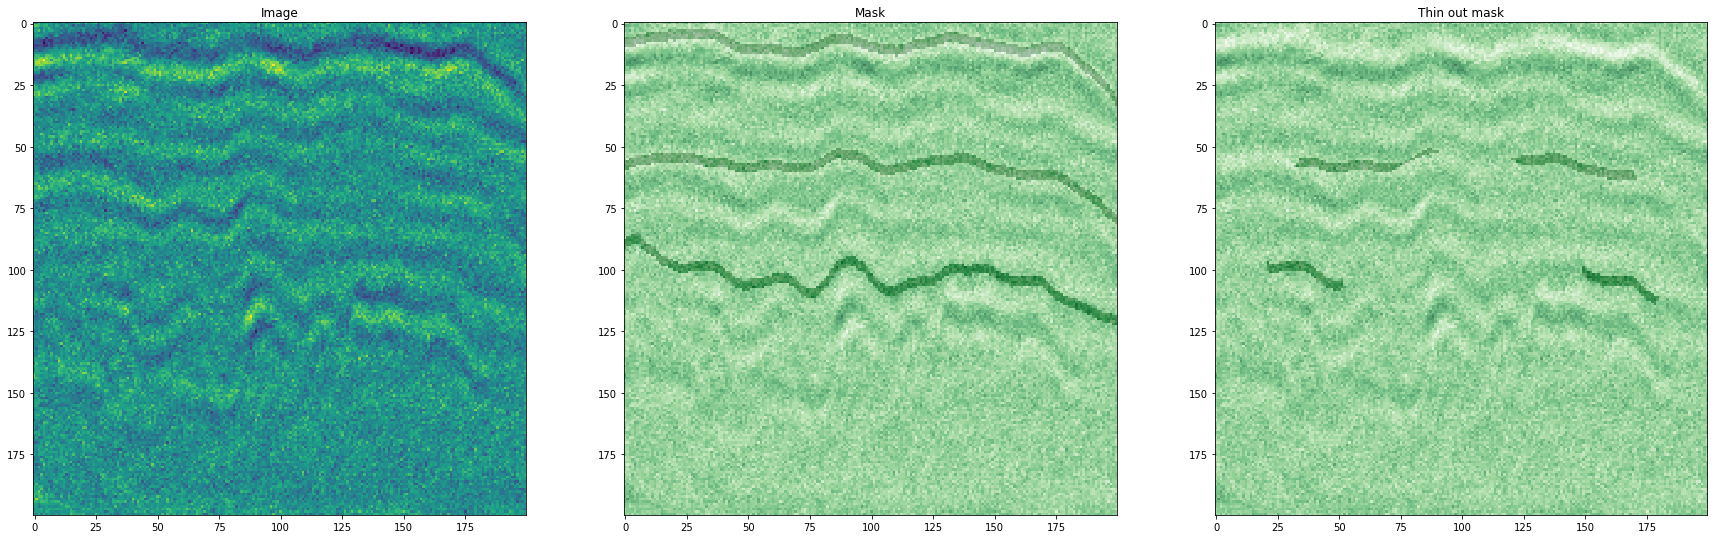

In [590]:
cv = 0.2
i = 1

_, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 15))
axes[0].imshow(btch.data_crops[i][0, :, :].T)
axes[0].set_title('Image')
axes[1].imshow(btch.data_crops[i][0, :, :].T, cmap='Greens')
axes[1].imshow(btch.mask_crops[i][0, :, :].T , cmap='Greens', alpha=0.3)
axes[1].set_title('Mask')
axes[2].imshow(btch.data_crops[i][0, :, :].T, cmap='Greens')
axes[2].imshow(btch.cut_mask_crops[i][0, :, :].T , cmap='Greens', alpha=0.3)
axes[2].set_title('Thin out mask')
plt.show()

In [499]:
INPUT_SHAPE = CROP_SHAPE[::-1]
INPUT_SHAPE_EXT = CROP_SHAPE[::-1][:2]
INPUT_SHAPE_EXT.extend([CROP_SHAPE[0] * 2])

MODEL_SHAPE_DICE = CROP_SHAPE[::-1] + [1]

INPUT_SHAPE = tuple(INPUT_SHAPE)
INPUT_SHAPE_EXT = tuple(INPUT_SHAPE_EXT)
MODEL_SHAPE_DICE = tuple(MODEL_SHAPE_DICE)

print(INPUT_SHAPE)
print(INPUT_SHAPE_EXT)
print(MODEL_SHAPE_DICE)

(200, 200, 1)
(200, 200, 2)
(200, 200, 1, 1)


In [500]:
def make_data_extension(batch, **kwargs):
    data_x = []
    for i, cube in enumerate(batch.data_crops):
        cube_ = np.swapaxes(cube, 0, 1)
        cube_ = np.swapaxes(cube_, 1, 2)
        cut_mask_ = np.swapaxes(batch.cut_mask_crops[i], 0, 1)
        cut_mask_ = np.swapaxes(cut_mask_, 1, 2)
        data_x.append(np.concatenate([cube_, cut_mask_], axis=-1))

    data_y = []
    
    for cube in batch.mask_crops:
        cube_ = np.swapaxes(cube, 0, 1)
        cube_ = np.swapaxes(cube_, 1, 2)
        data_y.append(cube_)
    return {"feed_dict": {'cubes': data_x,
                          'masks': np.expand_dims(data_y, axis=-1)}}

In [501]:
def make_data(batch, **kwargs):
    data_x = []
    for i, cube in enumerate(batch.data_crops):
        cube_ = np.swapaxes(cube, 0, 1)
        cube_ = np.swapaxes(cube_, 1, 2)
        data_x.append(cube_)

    data_y = []
    for cube in batch.mask_crops:
        cube_ = np.swapaxes(cube, 0, 1)
        cube_ = np.swapaxes(cube_, 1, 2)
        data_y.append(cube_)
    return {"feed_dict": {'cubes': data_x,
                          'masks': np.expand_dims(data_y, axis=-1)}}

# Model architecture

We use a small unet with custom upsampling

In [502]:
class PixelShuffle(UNet):
    def build_config(self, names=None):
        config = super().build_config(names)
        config['head/num_classes'] = CROP_SHAPE[0]
        return config

    @classmethod
    def decoder_block(cls, inputs, filters, upsample=None, decoder=None, name='decoder', **kwargs):
        upsample = cls.fill_params('body/upsample', **upsample)
        decoder = cls.fill_params('body/decoder', **decoder)

        with tf.variable_scope(name):
            x, skip = inputs
            inputs = None

            x = conv_block(x, layout='Cna', kernel_size=3,
                            filters=filters*4, strides=1, activation=tf.nn.elu,
                            name='prefix')
            x = tf.nn.depth_to_space(x, block_size=2, name='pixel_shuffle')

            x = cls.crop(x, skip, data_format=kwargs.get('data_format'))
            axis = cls.channels_axis(kwargs.get('data_format'))
            x = tf.concat((skip, x), axis=axis)
            x = conv_block(x, filters=filters, name='conv', **{**kwargs, **decoder})
        return x

In [503]:
def predictions(x):
    return tf.expand_dims(x, axis=-1, name='expand')

In [555]:
model_config = { 'initial_block/inputs': 'cubes',
                    'body/filters': [8, 16, 32, 64, 128],
                    'body/encoder': dict(layout='cna', kernel_size=3, activation=tf.nn.elu),
                    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.2),
                    'body/decoder': dict(layout='cna', kernel_size=3, activation=tf.nn.elu),
                    'body/upsample': dict(layout='tad', kernel_size=3, strides=2,
                                          dropout_rate=0.2, activation=tf.nn.elu),
                    'loss': 'dice',
                    'optimizer': 'Adam',
                    'output': 'sigmoid',
                    'predictions': predictions,
                     }

In [556]:
model_config_ext = {'inputs': dict(cubes={'shape': INPUT_SHAPE_EXT},
                                   masks={'name': 'targets', 'shape': MODEL_SHAPE_DICE}),
                    **model_config}

In [557]:
model_config_base = {'inputs': dict(cubes={'shape': INPUT_SHAPE},
                                   masks={'name': 'targets', 'shape': MODEL_SHAPE_DICE}),
                    **model_config}

# Training

In [558]:
train_pipeline = (train_load_ppl
                      .init_variable('ext_loss_history', init_on_each_run=list)
                      .init_variable('ext_current_loss')
                      .init_model('dynamic', PixelShuffle, 'extension', model_config_ext)
                      .train_model('extension',
                                   fetches='loss',
                                   make_data=make_data_extension,
                                   save_to=V('ext_current_loss'),
                                   use_lock=True)
                      .update_variable('ext_loss_history', V('ext_current_loss'), mode='a')
                      .init_variable('base_loss_history', init_on_each_run=list)
                      .init_variable('current_loss')
                      .init_model('dynamic', PixelShuffle, 'baseline', model_config_base)
                      .train_model('baseline',
                                   fetches='loss',
                                   make_data=make_data,
                                   save_to=V('current_loss'),
                                   use_lock=True)
                      .update_variable('base_loss_history', V('current_loss'), mode='a'))

In [ ]:
EPOCHS = 1000
train_pipeline.run(2, n_epochs=EPOCHS, drop_last=False, shuffle=True, bar=True)

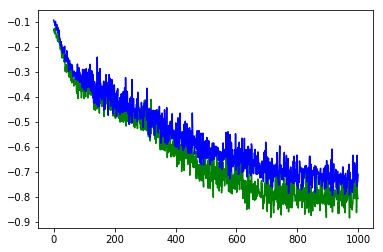

In [562]:
plt.plot(train_pipeline.get_variable('ext_loss_history'), color='g')
plt.plot(train_pipeline.get_variable('base_loss_history'), color='b')
plt.show()

# Inference

In [620]:
test_load_ppl = (Pipeline()
                  .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                  .crop(points=L(ds_test.sampler.sample, NUM_CROPS), shape=CROP_SHAPE)
                  .load_cubes(dst='data_crops')
                  .scale(mode='normalize', src='data_crops')
                  .create_masks(dst='mask_crops', mode='horizon')
           ) << ds_test

In [621]:
test_load_ppl = test_load_ppl + filter_mask_ppl

In [629]:
test_pipeline = (test_load_ppl
                 .import_model('extension', train_pipeline)
                 .init_variable('ext_result', init_on_each_run=list())
                 .predict_model('extension',
                                fetches=['sigmoid', 'cubes', 'masks'],
                                make_data=make_data_extension,
                                save_to=V('ext_result'), mode='a')
                 .init_variable('base_result', init_on_each_run=list())
                 .import_model('baseline', train_pipeline)
                 .predict_model('baseline',
                                fetches=['sigmoid', 'cubes', 'masks'],
                                make_data=make_data,
                                save_to=V('base_result'), mode='a'))

test_pipeline = (test_pipeline) << ds_test
test_pipeline.run(1, n_epochs=1)

# Model evaluation

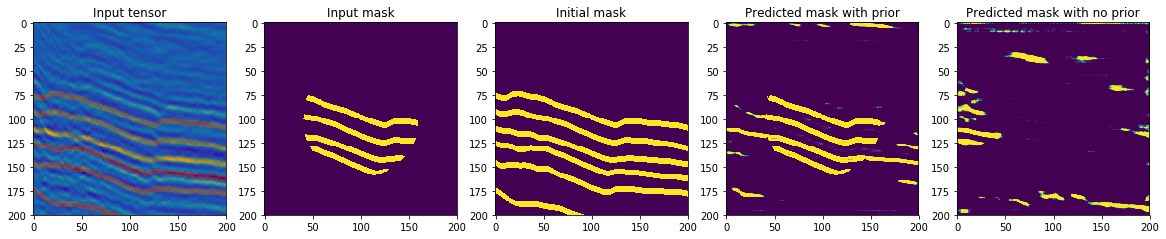

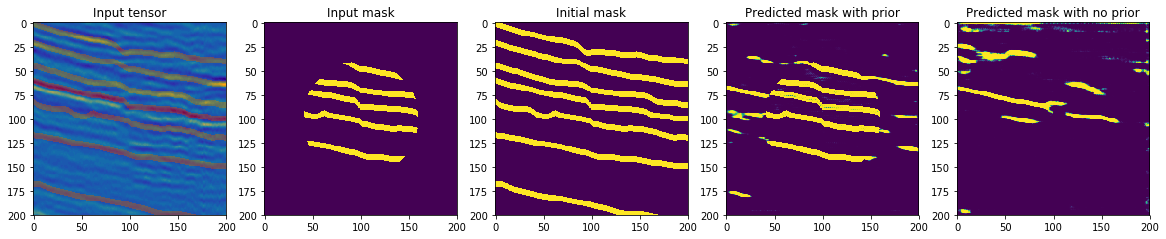

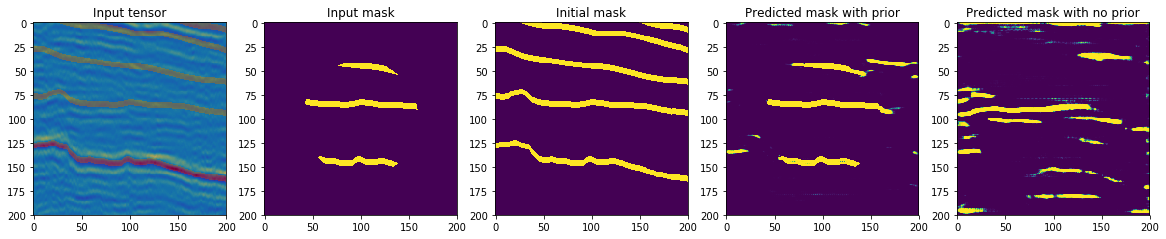

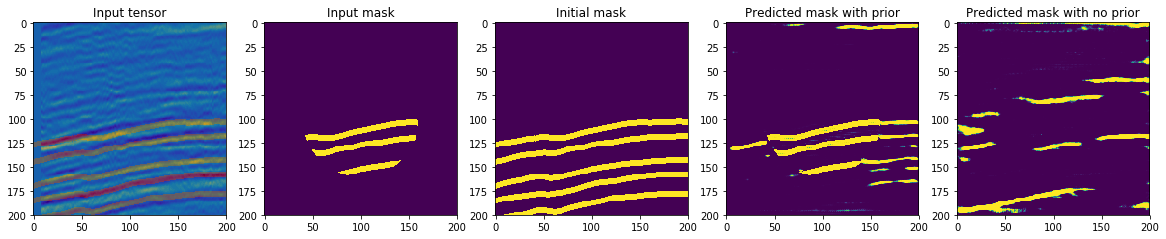

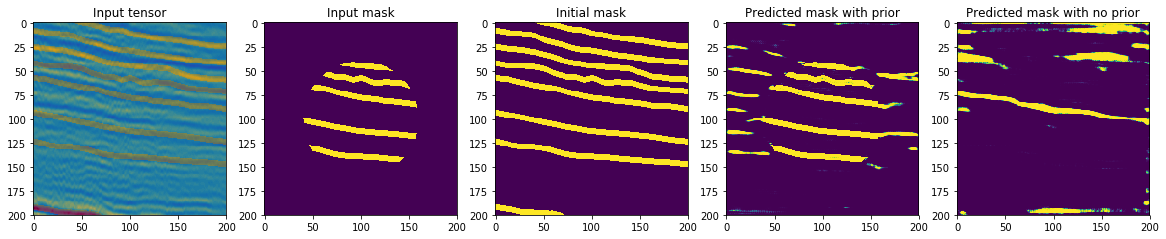

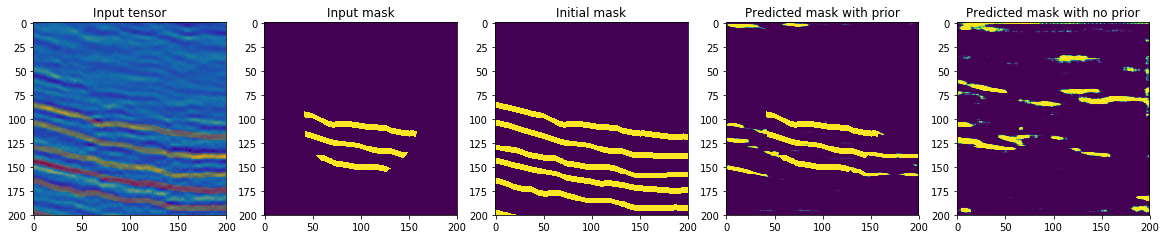

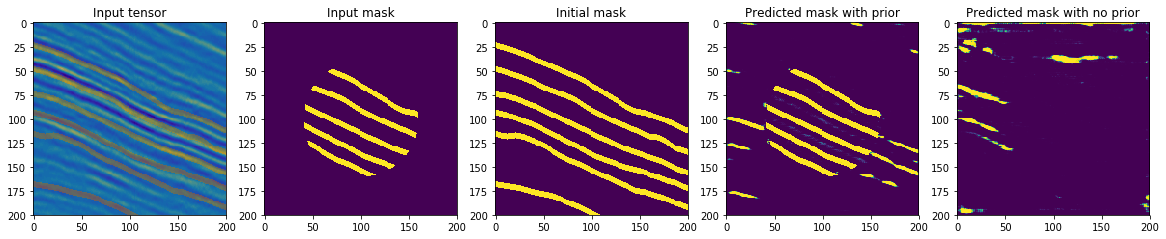

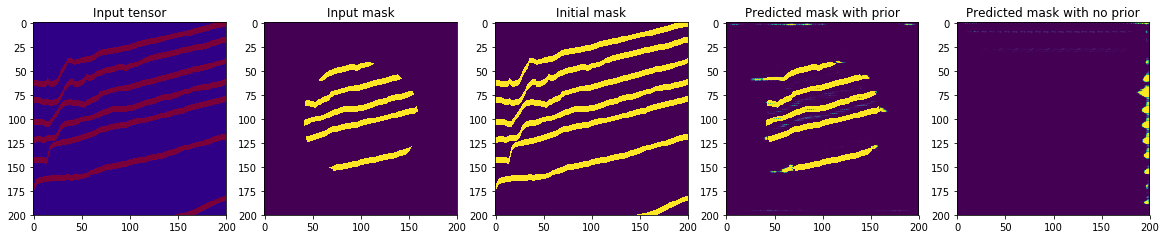

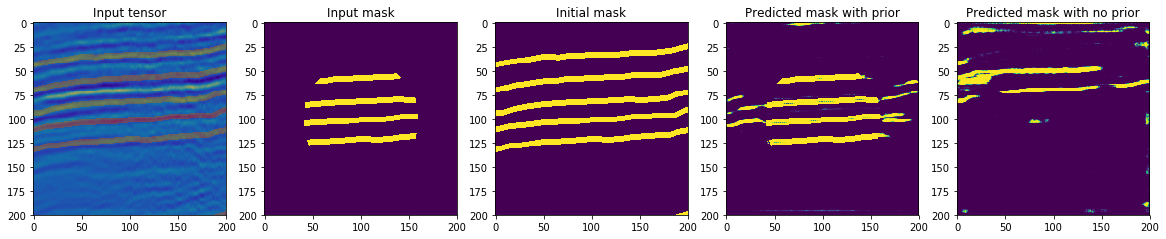

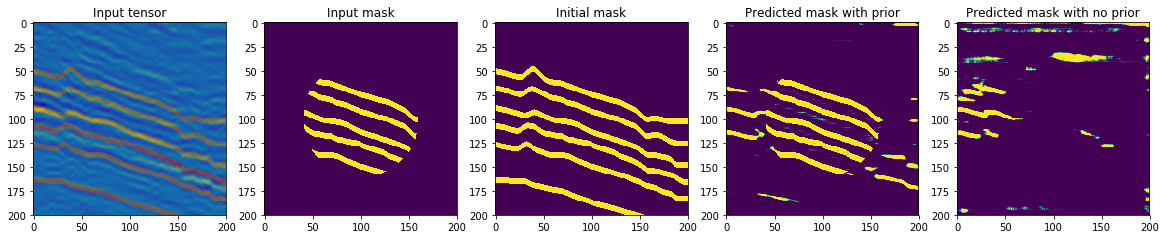

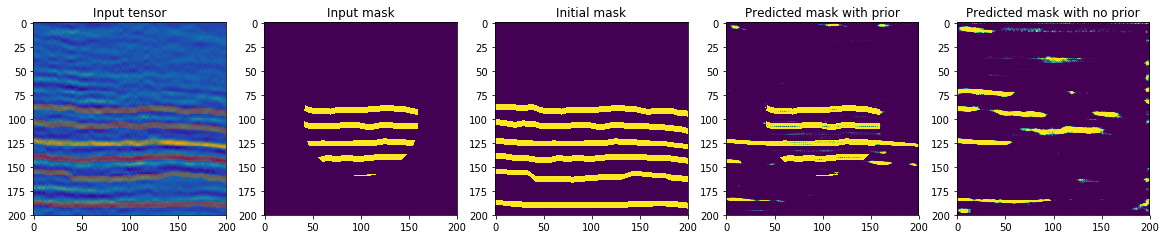

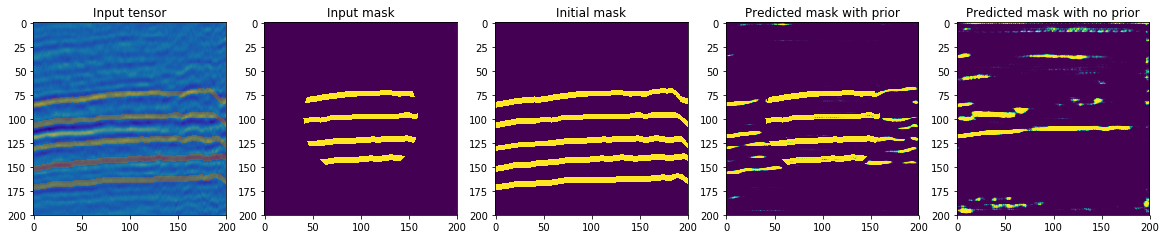

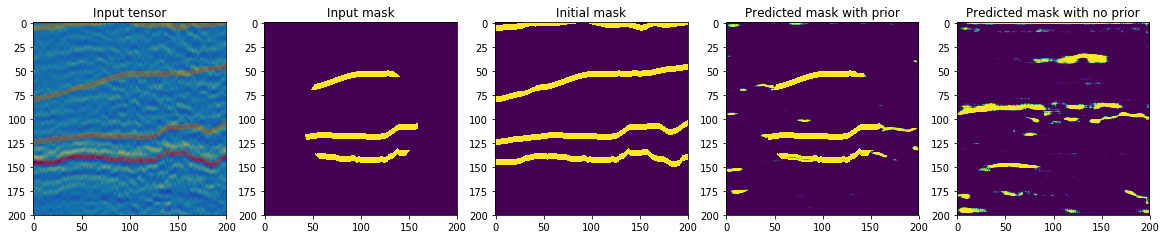

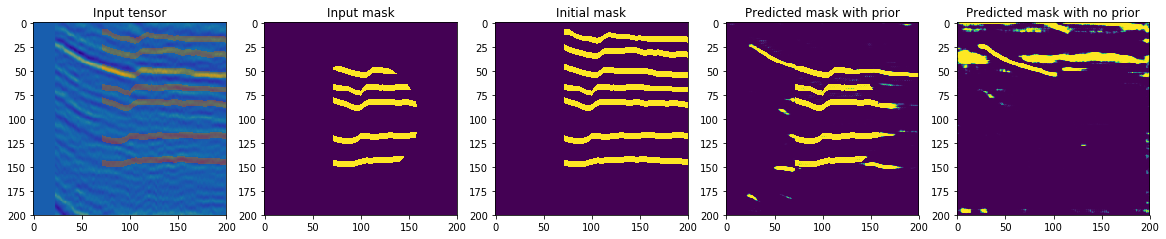

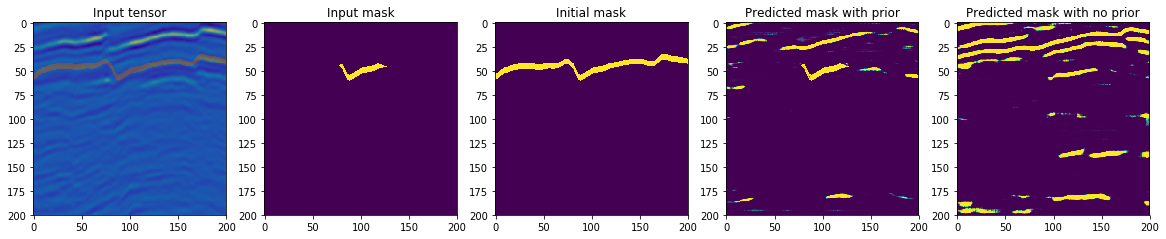

In [630]:
for cube in range(0, 15):
    iline = 0
    predicted_img = test_pipeline.get_variable('ext_result')[0][0][cube, :, :, :]
    truth_img =     test_pipeline.get_variable('ext_result')[0][1][cube, :, :, :]
    truth_labels =  test_pipeline.get_variable('ext_result')[0][2][cube, :, :, :]

    predicted_simple = test_pipeline.get_variable('base_result')[0][0][cube, :, :, :]

    cv = 0.1

    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 5, 1)
    plt.imshow(truth_img[:, :, 0].T)
    plt.imshow(truth_labels[:, :, 0].T[0], alpha=0.3, cmap='bwr')

    plt.title('Input tensor')
    
    fig.add_subplot(1, 5, 2)
    plt.imshow(truth_img[:, :, -1].T)
    plt.title('Input mask')
    
    fig.add_subplot(1, 5, 3)
    plt.imshow(truth_labels[:, :, 0].T[0])
    plt.title('Initial mask')
    
    fig.add_subplot(1, 5, 4)
    plt.imshow(predicted_img[:, :, 0].T)
#     plt.imshow(truth_labels[:, :, 0].T[0], alpha=0.3, cmap='bwr')
    plt.title('Predicted mask with prior')

    fig.add_subplot(1, 5, 5)
    plt.imshow(predicted_simple[:, :, 0].T)
#     plt.imshow(truth_labels[:, :, 0].T[0], alpha=0.3, cmap='bwr')

    plt.title('Predicted mask with no prior')
    plt.show()

# Criticism

Results do not look good for both tasks - extension and standard segmentation

# Proposals for the improvement and further development

Add more augmentations and achive good quality of the baseline model at first